<a href="https://colab.research.google.com/github/simon-mellergaard/GAI-with-LLMs/blob/main/Project%20codes/question1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1

Follow the classification example in Chapter 6 in Hands-On Generative AI with Transformers and Diffusion Models and extend it in the following ways:
1. Perform an error analysis based on the fine-tuned DestilBert model on the AG News dataset.
2. Fine-tune a ModernBert model (answerdotai/ModernBERT-base) in a similar fashion as DestilBert was fine-tuned in the chapter.
3. Compare the test set performance of the two fine-tuned models.
4. Perform an error analysis on the AG News based on the fine-tuned ModernBert and compare it to DestilBert.

## Setup

Loading all the needed functions, libraries and logging in to the services (HF and wandb)

In [17]:
# Logging in
from google.colab import userdata
import os
from huggingface_hub import login
import wandb
os.environ['HF_TOKEN'] = userdata.get('HF')
login(os.environ['HF_TOKEN'])
os.environ['WANDB_TOKEN'] = userdata.get('wandb')
wandb.login(key = os.environ['WANDB_TOKEN'])

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

## 1 Error based analysis

> *Perform an error analysis based on the fine-tuned DestilBert model on the AG News dataset.*

First, the data is loaded from HF.

In [1]:
# Loading the raw dataset from HuggingFace and making a training set.
from datasets import load_dataset

raw_datasets = load_dataset("ag_news") # 120.000 train rows and 7.600 test rows.
raw_train_dataset = raw_datasets["train"]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Here, the DistilBert model is used to tokenize the data. The data is being tokenized based on this.

In [2]:
from transformers import AutoTokenizer

checkpoint = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(batch):
    return tokenizer(
        batch["text"], truncation=True, padding=True, return_tensors="pt"
    )

tokenize_function(raw_train_dataset[:2])
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

The evaluation metrics are imported to eavalueate the datasets in terms of accuracy and F1-score.

In [3]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.5 MB/s eta 0:00:00


In [4]:
import evaluate

accuracy = evaluate.load("accuracy")
f1_score = evaluate.load("f1")

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Compute accuracy and F1 Score
    acc_result = accuracy.compute(references=labels, predictions=preds)
    acc = acc_result["accuracy"]

    f1_result = f1_score.compute(
        references=labels, predictions=preds, average="weighted"
    )
    f1 = f1_result["f1"]

    return {"accuracy": acc, "f1": f1}

The below code is specifying the model, and connecting it to the GPU.

In [5]:
import torch
from transformers import AutoModelForSequenceClassification

# defining a get_device function that gets the device of the system (gpu/cpu).
# This function is from the genaibook repository.
def get_device(cuda_ordinal=None):
    if torch.cuda.is_available():
        return torch.device("cuda", cuda_ordinal)
    if torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

device = get_device()
num_labels = 4
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=num_labels
).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Defining the model

In [6]:
from transformers import TrainingArguments

batch_size = 32  # COULD BE CHANGED
training_args = TrainingArguments(
    "classifier-distilbert-agnews",
    push_to_hub=True,
    num_train_epochs=2,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    #report_to="none"
)

Specifying the trainer

In [8]:
from transformers import Trainer

# Shuffle the dataset and pick 10,000 examples for training
shuffled_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_split = shuffled_dataset.select(range(10000))

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=small_split,
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
)

/tmp/ipython-input-946655670.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training the actual model.

In [15]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.276913,0.908684,0.908390
2,0.312800,0.261054,0.916447,0.916476


TrainOutput(global_step=626, training_loss=0.2892718939735486, metrics={'train_runtime': 699.6221, 'train_samples_per_second': 28.587, 'train_steps_per_second': 0.895, 'total_flos': 1875180164398464.0, 'train_loss': 0.2892718939735486, 'epoch': 2.0})

The model has now been trained, and it has a training accuracy of 91%, and an equally high F1 score. The validatino loss is 0.26. This is quite good, considering there are 4 classes to predict from.

In [18]:
trainer.push_to_hub()

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...assifier-chapter4/model.safetensors:   2%|2         | 6.16MB /  268MB            

  ...vents.1757510360.009a0d3d389f.803.0:   1%|          |  61.0B / 6.36kB            

  ...assifier-chapter4/training_args.bin:   1%|          |  55.0B / 5.78kB            

CommitInfo(commit_url='https://huggingface.co/simon-mellergaard/classifier-chapter4/commit/499d80a576f88637cd9d18026f0e5f08b6888e5a', commit_message='End of training', commit_description='', oid='499d80a576f88637cd9d18026f0e5f08b6888e5a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/simon-mellergaard/classifier-chapter4', endpoint='https://huggingface.co', repo_type='model', repo_id='simon-mellergaard/classifier-chapter4'), pr_revision=None, pr_num=None)

In [26]:
# Use a pipeline as a high-level help
from transformers import pipeline

pipe = pipeline(
    "text-classification",
    model="simon-mellergaard/classifier-distilbert-agnews",
    device="cuda",
)
pipe(
    """The soccer match between Spain and
Portugal ended in a terrible result for Portugal."""
)

Device set to use cuda


[{'label': 'Sports', 'score': 0.891423225402832}]

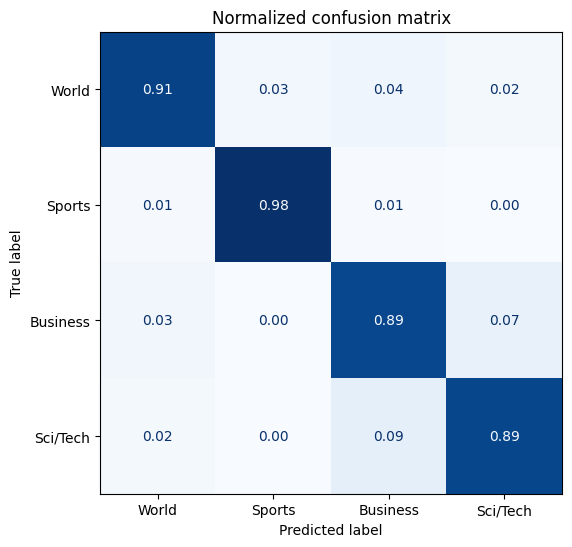

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
# Get the list of label names
label_names = raw_train_dataset.features["label"].names


# Convert predicted labels to ids
label_to_id = {name: i for i, name in enumerate(label_names)}
pred_labels = [label_to_id[pred["label"]] for pred in model_preds]

# Compute confusion matrix
confusion_matrix = evaluate.load("confusion_matrix")
cm = confusion_matrix.compute(
    references=references, predictions=pred_labels, normalize="true"
)["confusion_matrix"]

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
plt.title("Normalized confusion matrix")
plt.show()

In [ ]:
# The below code is supposed to change the labels so they match to their
# categories, but this does not so far. Instead use the website and edit
# directly.
# define mappings as dictionaries
id2label = {"LABEL_0": "world", "LABEL_1": "Sports", "LABEL_2": "Business", "LABEL_3": "Sci/Tech"}
label2id = {"world": "LABEL_0", "Sports": "LABEL_1", "Business": "LABEL_2", "Sci/Tech": "LABEL_3"}

# define config
config = AutoConfig.from_pretrained(model_name, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config = config)

## 2 Error based analysis on ModernBert

> *Fine-tune a ModernBert model (answerdotai/ModernBERT-base) in a similar fashion as DestilBert was fine-tuned in the chapter.*

The same analysis will be made, but this time with the [ModernBert library](https://huggingface.co/answerdotai/ModernBERT-base).
